### Training Dataset from sklearn

In [1]:
from sklearn.datasets import load_digits
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt


images, labels = load_digits(2, return_X_y = True)

# Labeled training set - training_images - 300 samples, 64 components
training_images = images[:300]
training_labels = labels[:300]

# Labeled test set
test_images = images[300:]
test_labels = labels[300:]

# Centering training data using mean vector
mean_vector = np.mean(training_images, axis = 0)
centered_training_images = training_images - mean_vector
centered_training_images = centered_training_images.transpose()

# Centering testing data using mean vector
centered_test_images = test_images - mean_vector
centered_test_images = centered_test_images.transpose()

#### k-NN Classification using 2-D Features

1. PCA of images in training set and computing 2D PCA features of training images

In [2]:
# SVD(centered_training_images) and taking top 2 principal components
U, S, Vtrans = LA.svd(centered_training_images)
U2 = U[:,0:2]

training_img_feat = U2.transpose().dot(centered_training_images)

print("Dimension of 2D PCA features of training images\n")
print(training_img_feat.shape)

Dimension of 2D PCA features of training images

(2, 300)


$\bullet$ Displaying 2D features of training images as points on 2D scatter plot: '0' in red, '1' in green

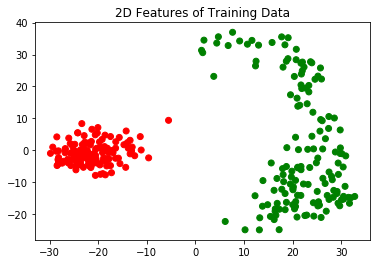

In [3]:
import matplotlib.pyplot as plt

X = training_img_feat[0,:]
Y = training_img_feat[1,:]

# Using training_labels to color map
colors = []
labels = np.concatenate((labels, training_labels))
for i in range(len(labels)):
    if(labels[i] == 0):
        colors.append("red")
    if(labels[i] == 1):
        colors.append("green")

        
plt.scatter(X, Y, c = colors)
plt.title("2D Features of Training Data")
plt.show()

2. Classifying each image in test set using top 2 principal components from Part 1

First implementing K-NN methods

In [4]:
import math
import operator

# 2D features of test images
test_img_feat = U2.transpose().dot(centered_test_images)

# Appending labels to training set as new row
train_set = np.vstack([training_img_feat, training_labels])


# Calculate euclidean distance between points
def getDistance(point1, point2, dim):
    dist = 0
    for i in range(dim):
        dist += pow(point1[i] - point2[i], 2)
    return math.sqrt(dist)
    

# Returns k-nearest neighbors list as: [training_label, distance]
def findKNN(train_set, test_point, k, dim):
    p_distances = []
    length_train_set = 300
    # Compute N distances from test point to all training points
    for i in range(length_train_set):
        # Omit last row, since appended label to train_set
        distance = getDistance(train_set[0:dim,i], test_point, dim)
        # Add paired elements: (train set label, distance to train set point)
        p_distances.append((train_set[dim,i], distance))
    # Now sort based on distance
    p_distances.sort(key = operator.itemgetter(1))
    neighbors = []
    for j in range(k):
        neighbors.append(p_distances[j])
    return neighbors

# Now classify single point using nearest neighbors' labels
def classify(neighbors):
    zero_count = 0;
    one_count = 0;
    for k in range(len(neighbors)):
        if(neighbors[k][0] == 0):
            zero_count += 1
        if(neighbors[k][0] == 1):
            one_count += 1
    if(zero_count > one_count):
        return 0
    if(one_count > zero_count):
        return 1

Now classifying each test image using K-NN with k = 5 and Euclidean distance.

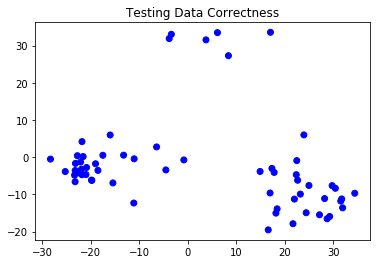

Correctly labeled data in 'blue', incorrectly labeled data in 'black'


In [5]:
def classifyImages(train_set, test, k, dim):
    tcheck_labels = []
    for i in range(60):
        neighbors = findKNN(train_set, test[:,i], k, dim)
        classification = classify(neighbors)
        tcheck_labels.append(classification)
    return tcheck_labels

testing_check = classifyImages(train_set, test_img_feat, 5, 2)
    
    
    
# Mapping correctness of scatter plot colors
Xtest = test_img_feat[0,:]
Ytest = test_img_feat[1,:]

# Using test_labels to color map      
colors_test = []
for i in range(len(testing_check)):
    if(testing_check[i] == test_labels[i]):
        colors_test.append("blue")
    if(testing_check[i] != test_labels[i]):
        colors_test.append("black")
        
plt.scatter(Xtest, Ytest, c = colors_test)
plt.title("Testing Data Correctness")
plt.show()

print("Correctly labeled data in 'blue', incorrectly labeled data in 'black'")

3. Computing average classfication error for the test set: $\frac{1}{N}\sum_{i=1}^{N} 1_{\hat{y_{i}}\neq{y_{i}}} $

In [6]:
N = 60
summation = 0;
for i in range(N):
    if(testing_check[i] != test_labels[i]):
        summation += 1;
print("The average classification error is = ", summation/N)

The average classification error is =  0.0


#### k-NN Classification using Higher Dimensional Features

1. We can take the eigen decomposition to find the eigen values of our training set. Then we can use: $\frac{\sum_{i}^{r}\lambda_{i}}{\sum_{i}^{n}\lambda_{i}}$ until this cumulative sum of eigen values yields the 0.95 ratio or 95% data variance that we want to keep.

In [7]:
# Using square of singular values from previous SVD to obtain eigenvals
eigenvals = np.square(S)

# Find principal components
def findR(eigenvals):
    numerator_sum = 0
    denominator = sum(eigenvals)
    r = 0;
    for i in range(64):
        numerator_sum += eigenvals[i]
        if(numerator_sum/denominator >= 0.95):
            r = i
            break
    return r

# 18 principal components
r_components = findR(eigenvals)
print("To capture 95% variance we will need ", r_components, " principal components")

To capture 95% variance we will need  18  principal components


Computing r = 18 dimensional PCA domain of images in training set

In [8]:
# Using U from previous SVD(centered_training_images)
U18 = U[:,0:18]

train_img_18D = U18.transpose().dot(centered_training_images)

print("Dimension of 18D PCA features of training images\n")
print(train_img_18D.shape)

Dimension of 18D PCA features of training images

(18, 300)


2. Classfying test set by transforming to 18D PCA domain, using k-NN with k = odd integer range (1,9), euclidean distance metric

In [9]:
# 18D features of test images
test_img_18D = U18.transpose().dot(centered_test_images)

# Appending labels to training set as new row
train_set_18D = np.vstack([train_img_18D, training_labels])

Now classifying all testing images with k values

In [10]:
# k = 1 classification
testing_k1 = classifyImages(train_set_18D, test_img_18D, 1, 18)

# k = 3 classification
testing_k3 = classifyImages(train_set_18D, test_img_18D, 3, 18)

# k = 5 classification
testing_k5 = classifyImages(train_set_18D, test_img_18D, 5, 18)

# k = 7 classification
testing_k7 = classifyImages(train_set_18D, test_img_18D, 7, 18)

# k = 9 classification
testing_k9 = classifyImages(train_set_18D, test_img_18D, 9, 18)

Text(0,0.5,'Avg. Classfication Error')

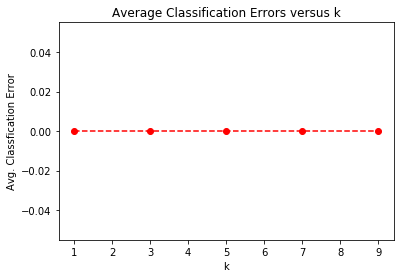

In [11]:
# Method to compute average classification error
def classError(testing, labels):
    N = 60
    summation = 0;
    for i in range(N):
        if(testing[i] != labels[i]):
            print("Hello?")
            summation += 1;
    return summation/N

# Computing classification errors for all k = 1 to 9
errors = []
err_k1 = classError(testing_k1, test_labels)
errors.append(err_k1)
err_k3 = classError(testing_k3, test_labels)
errors.append(err_k3)
err_k5 = classError(testing_k5, test_labels)
errors.append(err_k5)
err_k7 = classError(testing_k7, test_labels)
errors.append(err_k7)
err_k9 = classError(testing_k9, test_labels)
errors.append(err_k9)

# Plotting average classification error versus k
k = [1, 3, 5, 7, 9]
fig, ax = plt.subplots()
plot1 = ax.plot(k, errors, 'ro--')
ax.set_title('Average Classification Errors versus k')
ax.set_xlabel('k')
ax.set_ylabel('Avg. Classfication Error')

Elaborating on zero error for k = 1, 3, 5, 7, 9. After carefully stepping through my implementation severeal times - it is true that we should expect a non zero error as k increases. This is only logical since we are accounting for more nearest training set points which will decide our "test label". Upon comparing these computed labels, they are indeed equal to the actual test labels provided by sklearn. The only reason I can see this happening is because of the way the training set and tesing set look when overlaid on each other. There is significant seperation between the points of both classes which can ultimately cause our labels to maintain zero error as k increases. 

The implementation further explained: training set is mean centered using a mean vector. Testing set is also mean centered using training mean vector. Training set is projected onto r dimensional PCA domain using r top principal components. The same is done with the testing set with the same r top principal components from the training set. We then compute N distances for each test set point - where each distance is between the test point and training points. The respective training labels are included along with each distance (as a pair in a list). We then sort this list by distance and truncate the smallest k distances to obtain our "k nearest neighbors". Now each single test point label is decided based on the majority of the two training labels for the k smallest distances. The average classification error is then based on comparing the computed test label with sklearn's provided test labels. 

k value cannot be directly recommended based on these average classification results. Usually we want to choose k to minimize classification error but there are a few dependencies such as spread of data - we might choose too few points or too many points, dealing with outliers, variation of data, etc. The plot above is not useful.

The overlaid plot is shown below:

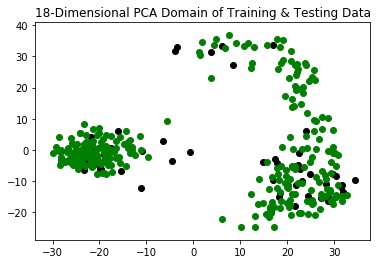

Training Data in Green, Testing Data in Black


In [12]:
X1 = test_img_18D[0,:]
Y1 = test_img_18D[1,:]

X2 = train_set_18D[0,:]
Y2 = train_set_18D[1,:]

plt.scatter(X1,Y1,color='k')
plt.scatter(X2,Y2,color='g')
plt.title("18-Dimensional PCA Domain of Training & Testing Data")
plt.show()
print("Training Data in Green, Testing Data in Black")